In [1]:
%pip install qiskit
%pip install qiskit_aer
%pip install qiskit_ibm_runtime
%pip install pylatexenc

  Using cached qiskit-2.1.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
Using cached qiskit-2.1.0-cp39-abi3-win_amd64.whl (7.2 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-transpiler-service 0.4.14 requires qiskit~=1.0, but you have qiskit 2.1.0 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from qiskit import QuantumCircuit,  transpile
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector,SparsePauliOp
from qiskit.result import marginal_counts
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

2 spin

In [3]:
fake_backend = FakeSherbrooke()
noisy_sim = AerSimulator.from_backend(fake_backend)

times = np.linspace(0, 2 * np.pi, 30)
n_steps = 10
shots = 1024
J = 1.0

def initial_state():
    qc = QuantumCircuit(2)
    qc.x(1)
    return qc

def trotter_step(qc, delta_t):
    qc.rxx(2 * J * delta_t, 0, 1)
    qc.ryy(2 * J * delta_t, 0, 1)
    qc.rzz(2 * J * delta_t, 0, 1)
    return qc

def time_evolve(T, n_steps):
    qc = initial_state()
    delta_t = T / n_steps
    for _ in range(n_steps):
        trotter_step(qc, delta_t)
    return qc

def compute_corr_ideal(t, obs):
    qc = time_evolve(t, n_steps)
    state = Statevector(qc)
    return state.expectation_value(SparsePauliOp(obs)).real

def run_noisy(qc):
    measured_qc = qc.copy()
    measured_qc.measure_all()
    tqc = transpile(measured_qc, backend=fake_backend)
    result = noisy_sim.run(tqc, shots=shots).result()
    return result.get_counts()

def compute_fidelity(ideal_qc, noisy_counts):
    state = Statevector(ideal_qc)
    total = sum(noisy_counts.values())
    return sum(np.abs(state[int(b, 2)])**2 * (count / total) for b, count in noisy_counts.items())

corr_z1z1, corr_z0z1, fidelities = [], [], []

for t in times:
    qc = time_evolve(t, n_steps)

    corr_z1z1.append(compute_corr_ideal(t, "IZ"))
    corr_z0z1.append(compute_corr_ideal(t, "ZI"))

    noisy_counts = run_noisy(qc)
    fidelities.append(compute_fidelity(qc, noisy_counts))

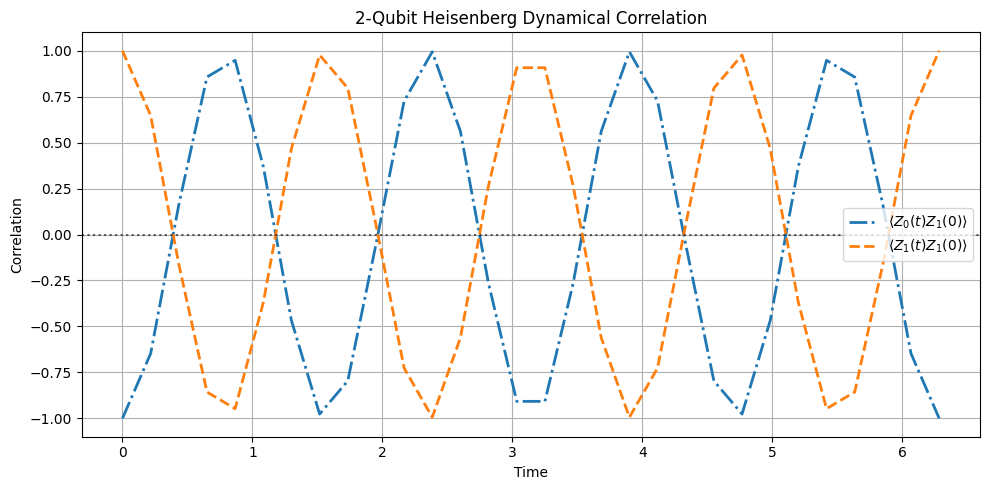

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(times, corr_z0z1, label=r'$\langle Z_0(t) Z_1(0) \rangle$', linestyle='-.', linewidth=2)
plt.plot(times, corr_z1z1, label=r'$\langle Z_1(t) Z_1(0) \rangle$', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle=':', alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title("2-Qubit Heisenberg Dynamical Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

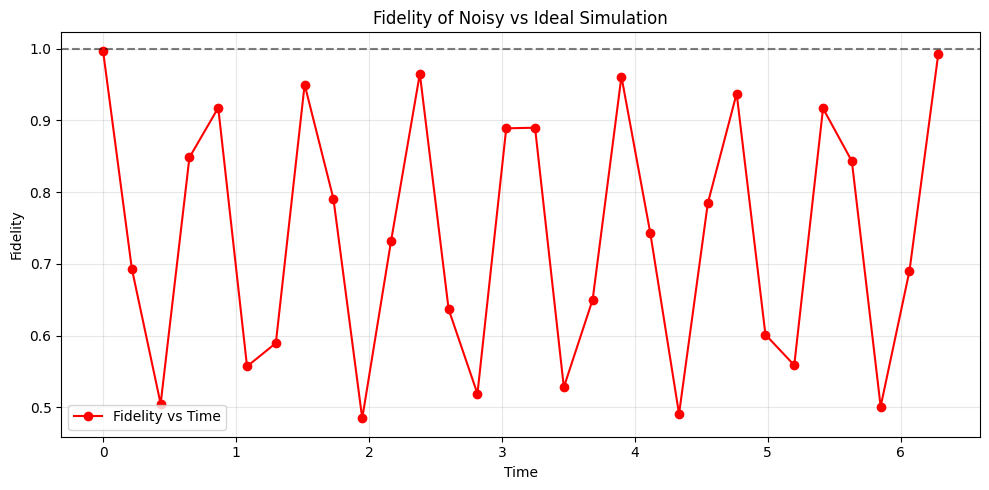

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(times, fidelities, 'ro-', label="Fidelity vs Time")
plt.axhline(1.0, color='k', ls='--', alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity of Noisy vs Ideal Simulation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


3 spin

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

fake_backend = FakeSherbrooke()
noisy_sim = AerSimulator.from_backend(fake_backend)

times = np.linspace(0, 2 * np.pi, 30)
n_steps = 10
shots = 1024
J = 1.0

def initial_state_3qubit():
    qc = QuantumCircuit(3)
    qc.x(1)
    return qc

def trotter_step(qc, delta_t):
    qc.rxx(2*J*delta_t, 0, 1)
    qc.ryy(2*J*delta_t, 0, 1)
    qc.rzz(2*J*delta_t, 0, 1)
    qc.rxx(2*J*delta_t, 1, 2)
    qc.ryy(2*J*delta_t, 1, 2)
    qc.rzz(2*J*delta_t, 1, 2)
    return qc

def time_evolve_3qubit(T, n_steps):
    qc = initial_state_3qubit()
    delta_t = T / n_steps
    for _ in range(n_steps):
        trotter_step(qc, delta_t)
    return qc

def compute_ideal_corr(t, pauli_string):
    qc = time_evolve_3qubit(t, n_steps)
    state = Statevector(qc)
    return state.expectation_value(SparsePauliOp(pauli_string)).real

def run_noisy_qasm(qc):
    measured = qc.copy()
    measured.measure_all()
    tqc = transpile(measured, backend=fake_backend)
    result = noisy_sim.run(tqc, shots=shots).result()
    return result.get_counts()

def compute_fidelity(qc, counts):
    ideal_state = Statevector(qc)
    total = sum(counts.values())
    return sum(
        np.abs(ideal_state[int(b, 2)])**2 * (count / total)
        for b, count in counts.items()
    )

corr_z0z1, corr_z1z1, corr_z2z1, fidelities = [], [], [], []
for t in times:
    qc = time_evolve_3qubit(t, n_steps)
    corr_z0z1.append(compute_ideal_corr(t, "ZIZ"))
    corr_z1z1.append(compute_ideal_corr(t, "IZZ"))
    corr_z2z1.append(compute_ideal_corr(t, "ZZI"))
    noisy_counts = run_noisy_qasm(qc)
    fidelities.append(compute_fidelity(qc, noisy_counts))


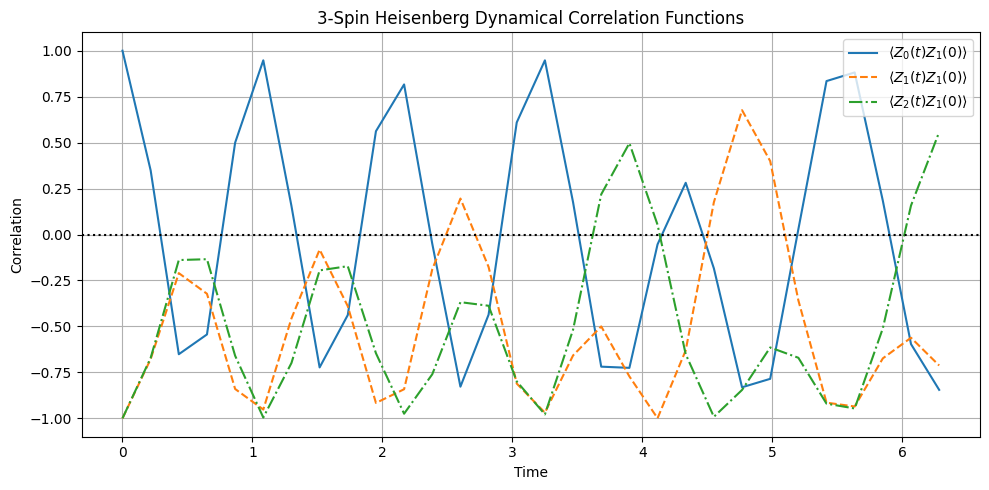

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(times, corr_z0z1, label=r'$\langle Z_0(t)Z_1(0) \rangle$', linestyle='-')
plt.plot(times, corr_z1z1, label=r'$\langle Z_1(t)Z_1(0) \rangle$', linestyle='--')
plt.plot(times, corr_z2z1, label=r'$\langle Z_2(t)Z_1(0) \rangle$', linestyle='-.')
plt.axhline(0, color='black', linestyle=':')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('3-Spin Heisenberg Dynamical Correlation Functions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


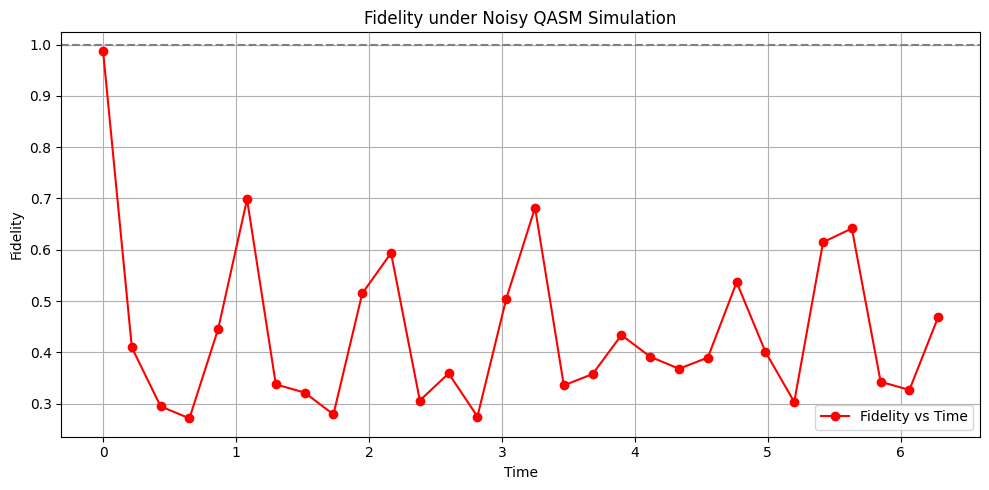

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(times, fidelities, 'ro-', label='Fidelity vs Time')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity under Noisy QASM Simulation')
plt.axhline(1.0, color='gray', linestyle='--')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()